In [1]:
import os
import sys
sys.path.append('../')

from IPython.core.pylabtools import figsize

#from utils import get_intervals
from utils import get_scanpy_lfcs, get_seurat_lfcs, get_ZILN_lfcs, transform, compute_p_vals

In [2]:
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.multitest as smm
from sklearn.metrics import confusion_matrix

In [3]:
def log_transform(x, scale_factor=10000):
    norm_x = np.log(scale_factor * x/x.sum(0))
    return(norm_x)

# x numpy vector of counts
# transformation to apply to the non-zero elements of x.
def process_counts(x, transformation):
    cell_count = len(x)
    N_0 = np.sum(x == 0)
    N_plus = cell_count - N_0
    t_x = transformation(x[np.where(x > 0)])    
    return(t_x, N_plus, N_0)

# return p-value -- we are using Normal assumption on the means for inference. The null is that the means are the same.
def infer_lfc(m_x, s_x, m_y, s_y):
    diff = m_x - m_y 
    s_hat = np.sqrt((s_x**2) + (s_y**2))
    lb = diff - 1.96*s_hat
    ub = diff + 1.96*s_hat
    # Compute the p-value.
    z_score = diff / s_hat
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
    return(lb,ub,p_value)


In [4]:
# Read in the counts data
data_folder = "../simul/splatter/"
X = pd.read_csv(os.path.join(data_folder, "X.csv")).to_numpy()
Y = pd.read_csv(os.path.join(data_folder, "Y.csv")).to_numpy()
#cell_counts_X = X.sum(axis=1)
#cell_counts_Y = Y.sum(axis=1)
n_genes = Y.shape[0]
n_cells = Y.shape[1]
print("n_genes: ", n_genes)
print("n_cells: ", n_cells)
print("shape X:", X.shape)
print("shape Y:", Y.shape)

lfcs = pd.read_csv(os.path.join(data_folder, "fc.csv"))
lfcs2 = pd.read_csv(os.path.join(data_folder, "fc2.csv"))
#idx = np.argsort(lfcs)

# Y_A = Y[:,X.loc[X["trt"] == "A"].index]
# Y_B = Y[:,X.loc[X["trt"] == "B"].index]
# print(Y_A.shape)
# print(Y_B.shape)


n_genes:  4043
n_cells:  973
shape X: (4043, 1027)
shape Y: (4043, 973)


In [5]:
X = X.transpose()
Y = Y.transpose()

n_genes = Y.shape[0]
n_cells = Y.shape[1]
print("shape Y:", Y.shape)

shape Y: (973, 4043)


In [13]:
ziln_lfcs, p_vals = get_ZILN_lfcs(np.exp(transform(Y)) - 1, np.exp(transform(X)) - 1, eps=1e-3, return_p_vals=True)

In [49]:
adj_pvals = smm.multipletests(p_vals, alpha=0.05, method='fdr_bh')[1]
adj_pvals

array([5.07030112e-01, 5.07030112e-01, 6.04173207e-01, ...,
       5.07030112e-01, 5.07030112e-01, 2.32613231e-04])

In [50]:
pred_sig_idx = (adj_pvals < 0.05)

In [51]:
gt_sig_idx = (lfcs["true_log2_fc"] != 0)

In [56]:
conf_mat = confusion_matrix(gt_sig_idx, pred_sig_idx)
conf_mat

array([[3255,    5],
       [ 719,   64]])

In [55]:
tn, fp, fn, tp = conf_mat.ravel()

3255


In [53]:
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate (Recall)
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate

# Print results
print(f"TPR: {tpr:.2f}")
print(f"TNR: {tnr:.2f}")
print(f"FPR: {fpr:.2f}")
print(f"FNR: {fnr:.2f}")

TPR: 0.08
TNR: 1.00
FPR: 0.00
FNR: 0.92


In [8]:
gt_lfcs = lfcs["true_log2_fc"]

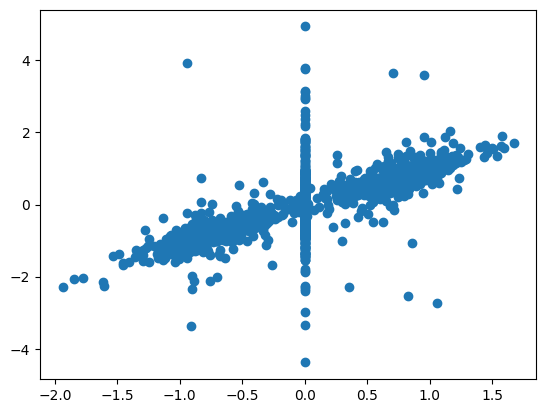

In [9]:
plt.scatter(gt_lfcs, ziln_lfcs)

<function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>

In [10]:
# seurat_lfcs = get_seurat_lfcs(Y.transpose(), X.transpose(), normalize=True)
seurat_lfcs = get_seurat_lfcs(Y, X, normalize=True)
scanpy_lfcs = get_scanpy_lfcs(Y, X, normalize=True)
#seurat_lfcs = get_seurat_lfcs(Y, X, normalize=True)

In [11]:
ii = (ziln_lfcs == np.inf) | (ziln_lfcs == -np.inf)
jj = np.isnan(lfcs2["avg_log2FC"])
print(np.where(ii))
kk = ii | jj

(array([], dtype=int64),)


In [12]:
np.mean((ziln_lfcs[~kk] - gt_lfcs[~kk])**2)

0.18484965862606698

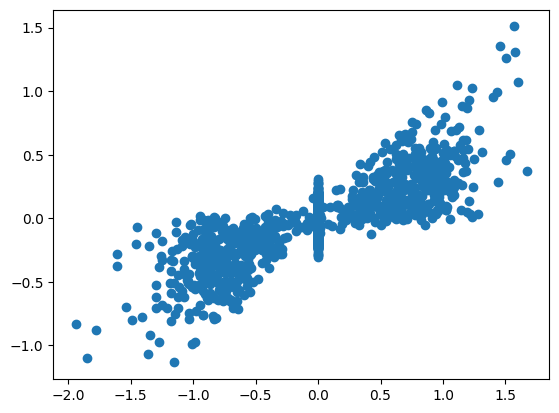

In [13]:
plt.scatter(gt_lfcs, seurat_lfcs)

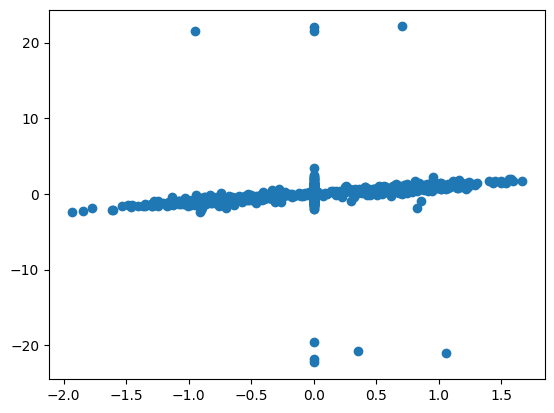

In [14]:
plt.scatter(gt_lfcs, scanpy_lfcs)

/var/folders/l2/ccntntgs5_d2w4xzpc9mgh680000gp/T/ipykernel_66001/1079119450.py:3: RuntimeWarning: divide by zero encountered in divide
  unb_lfcs = np.log2(unb_x_est/unb_y_est)
/var/folders/l2/ccntntgs5_d2w4xzpc9mgh680000gp/T/ipykernel_66001/1079119450.py:3: RuntimeWarning: invalid value encountered in divide
  unb_lfcs = np.log2(unb_x_est/unb_y_est)
/var/folders/l2/ccntntgs5_d2w4xzpc9mgh680000gp/T/ipykernel_66001/1079119450.py:3: RuntimeWarning: divide by zero encountered in log2
  unb_lfcs = np.log2(unb_x_est/unb_y_est)


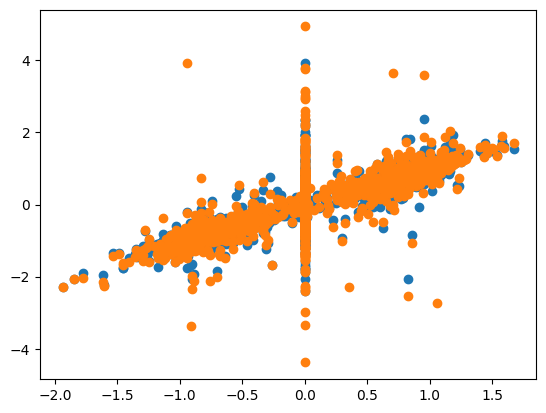

In [15]:
unb_y_est = np.mean(Y, 0)
unb_x_est = np.mean(X, 0)
unb_lfcs = np.log2(unb_x_est/unb_y_est)
plt.scatter(gt_lfcs, unb_lfcs)
plt.scatter(gt_lfcs, ziln_lfcs)
plt.show()